In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# data analysis and wrangling
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
from ipywidgets import interact

# machine learning 
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,classification_report,make_scorer,f1_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier,plot_importance
import MyClassAndFun as MCF

In [3]:
df=pd.read_csv('transformed__dumm_train.csv')
df.drop(['id','customer_id','month','ssn_aaa','monthly_inhand_salary','delay_from_due_date'], axis=1, inplace=True)#,
       #  'num_credit_card','interest_rate'], axis=1, inplace=True)
X=df.drop('credit_score', axis=1)
y=df['credit_score']
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.1, random_state=1,stratify=y)
from sklearn.preprocessing import PowerTransformer
pt=PowerTransformer(method='yeo-johnson', standardize=True, copy=True)
transform_var_list=['age','annual_income','changed_credit_limit',#'delay_from_due_date',,'interest_rate'
                    'credit_utilization_ratio','credit_history_monts',#'outstanding_debt',
                    'num_of_delayed_payment','total_emi_per_month','amount_invested_monthly','monthly_balance',]
for i in transform_var_list:
    X_train[i]=pt.fit_transform(X_train[[i]])
    X_test[i]=pt.transform(X_test[[i]])
X_train_df=pd.DataFrame(X_train,columns=X.columns)
X_test_df=pd.DataFrame(X_test,columns=X.columns)
combined_df = pd.concat([X_train_df, y_train], axis=1)
test_results = MCF.perform_tests(combined_df)
# print(test_results.sort_values(by="t-statistic", ascending=False))
X_test_df=X_test_df[list(test_results.loc[test_results['p-value']==0].column)]
X_train_df=X_train_df[list(test_results.loc[test_results['p-value']==0].column)]

In [4]:
from imblearn.over_sampling import SMOTE

# Подсчет количества экземпляров каждого класса
unique, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(unique, counts))
# Вычисление на сколько увеличить каждый класс на 20%
sampling_strategy = {key: int(value * 1.2) for key, value in class_counts.items()}

# Создание объекта SMOTE с указанием sampling_strategy в виде словаря
smote = SMOTE(sampling_strategy=sampling_strategy)
X_train_df, y_train = smote.fit_resample(X_train_df, y_train)
#SMOTE
smote = SMOTE()
X_train_df, y_train = smote.fit_resample(X_train_df, y_train)

C:\Users\elper\anaconda3\lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (63808) in class 1 will be larger than the number of samples in the majority class (class #1 -> 47857)
  warnings.warn(


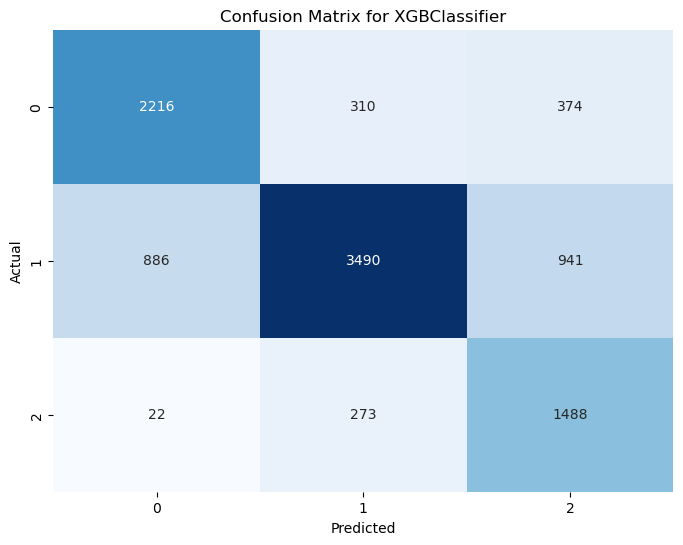

Classification Report for XGBClassifier:

              precision    recall  f1-score   support

           0       0.71      0.76      0.74      2900
           1       0.86      0.66      0.74      5317
           2       0.53      0.83      0.65      1783

    accuracy                           0.72     10000
   macro avg       0.70      0.75      0.71     10000
weighted avg       0.76      0.72      0.72     10000



In [5]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Creating XGBClassifier model with multi-class classification metrics set
XGBoost_C = XGBClassifier(
    learning_rate=0.1,
    max_depth=5,
    n_estimators=256,
    objective='multi:softprob',  # Use multi:softprob for multi-class classification
    random_state=42,
    n_jobs=-1,
    eval_metric=["merror", "mlogloss"]  # Set appropriate metrics
)

eval_set = [(X_train_df, y_train), (X_test_df, y_test)]

# Training the model using eval_metric for multi-class classification
XGBoost_C.fit(X_train_df, y_train, eval_set=eval_set, verbose=False)
XGBoost_pred = XGBoost_C.predict(X_test_df)

# Calculating confusion matrix and classification report
confusion = confusion_matrix(y_test, XGBoost_pred)
report = classification_report(y_test, XGBoost_pred)

# Plotting a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for XGBClassifier')
plt.show()

# Printing the classification report
print("Classification Report for XGBClassifier:\n")
print(report)


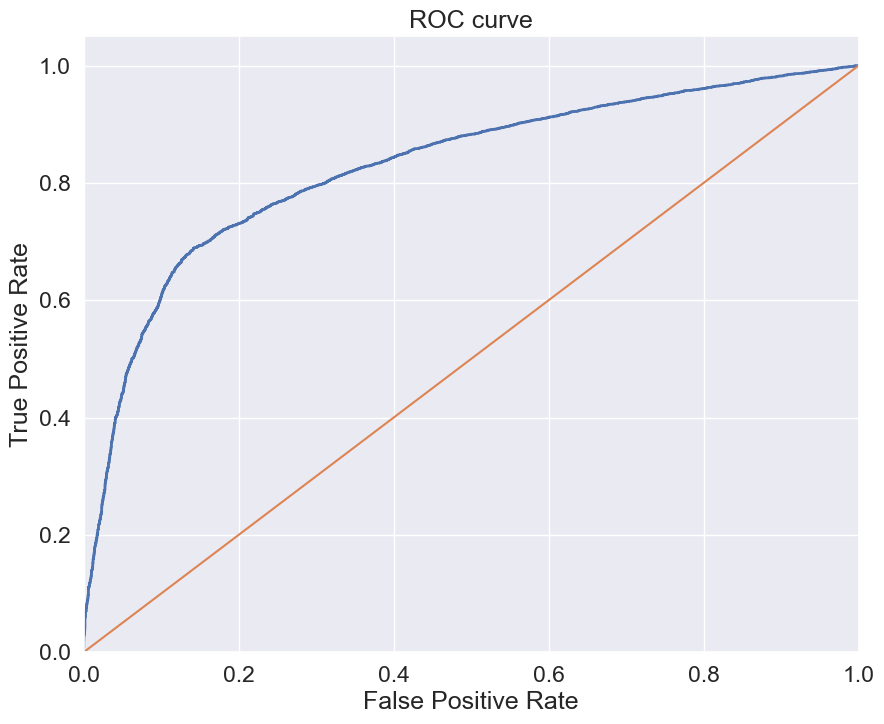

In [6]:
MCF.ROC_curve(XGBoost_C,X_test_df,y_test)

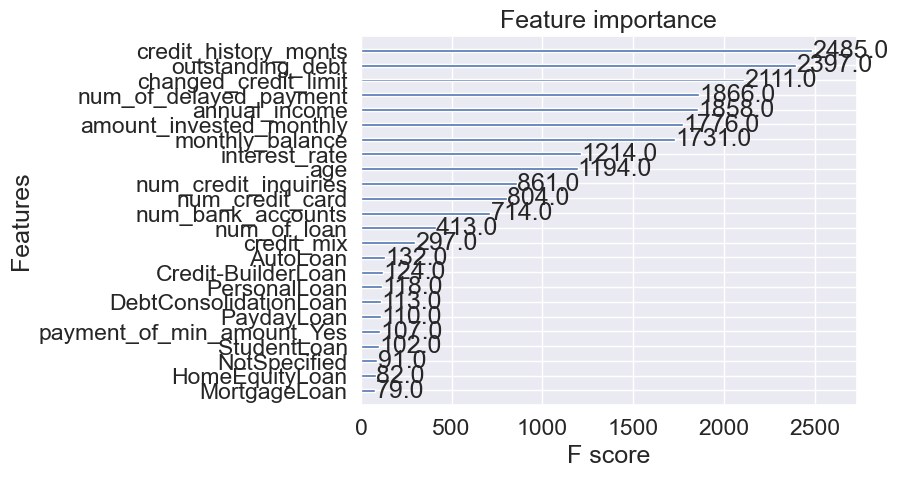

In [7]:
plot_importance(XGBoost_C)
plt.show()

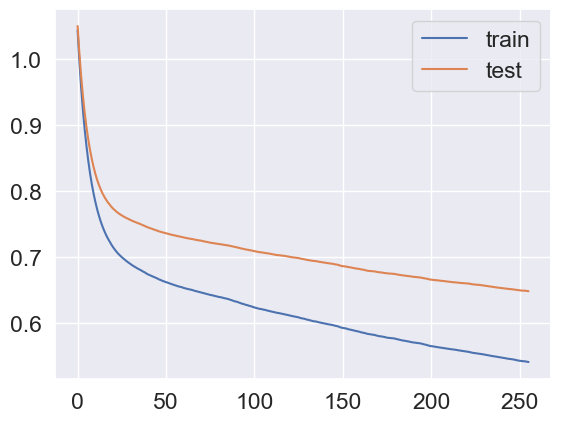

In [8]:
# Get the training results
results = XGBoost_C.evals_result()

# Plot the learning curves for logloss for the training and test datasets
plt.plot(results['validation_0']['mlogloss'], label='train')
plt.plot(results['validation_1']['mlogloss'], label='test')

# Show the legend
plt.legend()

# Show the plot
plt.show()
